In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from processing import preprocessing
from cross_validation import TimeBasedCV, time_cross_val_scores

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = preprocessing('./data/data_regression_for_task.csv')
data.shape

(122821, 44)

Разделим данные на train/test. В test строки за последний месяц - 02.2018.

In [128]:
data_test = data[data['YEAR_MONTH'] == 10]
data_train = data.drop(data_test.index)

y_test = data_test['SALES']
X_test = data_test.drop(['SALES'], axis=1)

y_train = data_train['SALES']
X_train = data_train.drop(['SALES'], axis=1)

y = data['SALES']
X = data.drop(['SALES'], axis=1)

Посмотрим есть ли в последнем месяце товары, не встречающиеся ранее. 

In [4]:
new_products = set(X_test['ARTICLE_NAME']) - set(X_train['ARTICLE_NAME'])
print("Новых товаров за последний месяц: ", len(new_products))
print("Новых товаров {:.2f}%".format(100*len(new_products)/X_test['ARTICLE_NAME'].nunique()))

Новых товаров за последний месяц:  622
Новых товаров 4.76%


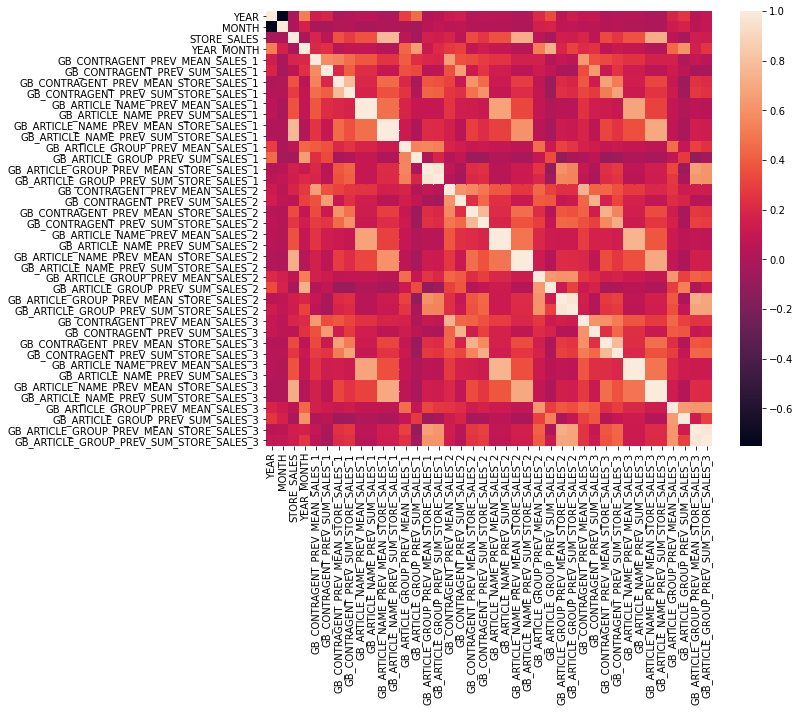

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

### Metrics

In [6]:
def metric(y_true, y_pred):
    EPS = 1e-8
    return 100*np.sum(np.abs(y_true - y_pred))/(np.sum(y_pred)+ EPS)

def root_mean_squared_error(*args, **kwargs):
    return np.sqrt(mean_squared_error(*args, **kwargs))

errors = {
    'main metric': metric,
    'RMSE': root_mean_squared_error,
    'MAE' : mean_absolute_error,
    'R2' : r2_score,
}

results = pd.DataFrame(index=list(errors.keys()))

### Baselines
Самый тривиальный baseline - прогнозировать следующее значение, такое же как и предыдущее.

In [97]:
y_pred = data_train['GB_ARTICLE_NAME_PREV_MEAN_SALES_1'].values
y_true = data_train['SALES'].values

for name, error in errors.items():
    results.loc[name, 'Trivial'] = format(error(y_true, y_pred), '.2f') 
results

,Trivial
main metric,69.19
RMSE,18601.13
MAE,3716.56
R2,0.62


Теперь попробуем классические модели для регрессии.

In [16]:
models = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'Dtree': DecisionTreeRegressor(),
    'RFR_10': RandomForestRegressor(n_estimators=10),
    'RFR_100': RandomForestRegressor(n_estimators=100),
    'NN' : MLPRegressor(activation='relu'),
}

pipelines = [
    Pipeline([
        ('Encoder', TargetEncoder(cols=['CONTRAGENT', 'ARTICLE_NAME', 'ARTICLE_GROUP'])),
        ('Scaler', StandardScaler()),
        ('Model', model)
    ])
    for model in models.values()
]


In [17]:
tscv = TimeBasedCV(train_period=4, test_period=1, split_column='YEAR_MONTH') 
cv_inds = tscv.split(X_train)

scoring = dict()
for key in errors.keys():
    if key != 'R2':
        scoring[key] = make_scorer(errors[key], greater_is_better=False)
    else:
        scoring[key] = make_scorer(errors[key], greater_is_better=True)

In [102]:
for m, m_name in zip(pipelines, models):
    results[m_name]  = pd.Series(time_cross_val_scores(m, X_train, y_train, cv=cv_inds, scoring=scoring))
    
results.round(2)

,Trivial,LinearRegression,Ridge,Lasso,Dtree,RFR_10,RFR_100,NN
main metric,69.19,325.68,75.74,56.01,47.64,42.22,41.34,56.24
RMSE,18601.13,14655.66,12755.44,12552.93,13650.29,12453.38,12276.10,12711.62
MAE,3716.56,7655.95,4957.94,4172.81,3477.32,3101.33,3051.40,3600.98
R2,0.62,0.79,0.84,0.85,0.82,0.85,0.85,0.84


### XGBoost

In [24]:
xgb_param_grid = {
   # subsample ratio of columns when constructing each tree
   'Model__colsample_bytree':[0.4, 0.6, 0.8],
   # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
   # The larger gamma is, the more conservative the algorithm will be.
   'Model__gamma':[0, 0.1, 0.3], 
   # corresponds to minimum number of instances needed to be in each node. 
   # The larger min_child_weight is, the more conservative the algorithm will be.
   'Model__min_child_weight':[4, 6], 
   # Step size shrinkage used in update to prevents overfitting.
   # LR shrinks the feature weights to make the boosting process more conservative.
   'Model__learning_rate':[0.3, 0.1, 0.01, 0.001], 
   # Increasing this value will make the model more complex and more likely to overfit
   'Model__max_depth':[5, 6, 7],
   'Model__n_estimators':[50, 100, 500, 700],
   # L1 regularization term on weights
   'Model__reg_alpha':[0, 0.1, 0.01, 0.9],
   # L2 regularization term on weights
   'Model__reg_lambda':[0, 0.1, 0.01, 0.9],
   # Subsample ratio of the training instances. This will prevent overfitting.   
   # Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees.
   'Model__subsample':[0.1, 0.5, 0.7, 0.9] 
}

xgb_pipe = Pipeline([
        ('Encoder', TargetEncoder(cols=['CONTRAGENT', 'ARTICLE_NAME','ARTICLE_GROUP'])),
        ('Scaler', StandardScaler()),  
        ('Model', XGBRegressor(objective ='reg:squarederror', predictor = 'cpu_predictor',
                               eval_metric = scoring['main metric']))
    ])
grid = RandomizedSearchCV(estimator=xgb_pipe, n_iter=20, param_distributions=xgb_param_grid, 
                          cv=cv_inds, scoring=scoring, refit='main metric', n_jobs=-1)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=[(Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            80413, 80414, 80415, 80416, 80417, 80418, 80419, 80420, 80421,
            80422],
           dtype='int64', length=53883),
                        Int64Index([ 6924,  6925,  6926,  6927,  6928,  6929,  6930,  6931,  6932,
             6933,
            ...
            88751, 88752, 88753, 88754, 88755, 88756, 88757, 88758, 88759,
            88760],
           dtype='int64', length=13588)),
                       (Int64Index([ 1731,  1732,  1733,  1734,  1735,  1736,  1737...
                                        'Model__reg_alpha': [0, 0.1, 0.01, 0.9],
                                        'Model__reg_lambda': [0, 0.1, 0.01,
                                                              0.9],
                                        'Model__subsample': [0.1, 0.5, 0.7,
                                                             0.9]},
   

In [103]:
results['XGB'] = pd.Series(
    time_cross_val_scores(grid.best_estimator_, X_train, y_train, cv=cv_inds, scoring=scoring))
results.round(2)

,Trivial,LinearRegression,Ridge,Lasso,Dtree,RFR_10,RFR_100,NN,XGB
main metric,69.19,325.68,75.74,56.01,47.64,42.22,41.34,56.24,40.02
RMSE,18601.13,14655.66,12755.44,12552.93,13650.29,12453.38,12276.10,12711.62,12139.57
MAE,3716.56,7655.95,4957.94,4172.81,3477.32,3101.33,3051.40,3600.98,2982.06
R2,0.62,0.79,0.84,0.85,0.82,0.85,0.85,0.84,0.86


In [26]:
grid.best_estimator_

Pipeline(steps=[('Encoder',
                 TargetEncoder(cols=['CONTRAGENT', 'ARTICLE_NAME',
                                     'ARTICLE_GROUP'])),
                ('Scaler', StandardScaler()),
                ('Model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.8,
                              eval_metric=make_scorer(metric, greater_is_better=False),
                              gamma=0, gpu_id=-1, importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=7, min_child_weight=4,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=4, num_parallel_tree=1,
                              predictor='cpu_predictor', random_state=0,
                              reg_alpha=0.01, r

In [27]:
grid.best_params_

{'Model__subsample': 0.7,
 'Model__reg_lambda': 0.1,
 'Model__reg_alpha': 0.01,
 'Model__n_estimators': 100,
 'Model__min_child_weight': 4,
 'Model__max_depth': 7,
 'Model__learning_rate': 0.1,
 'Model__gamma': 0,
 'Model__colsample_bytree': 0.8}

In [42]:
n = 15
fi = pd.Series(grid.best_estimator_.steps[-1][1].feature_importances_,
               index=X_train.columns)
important_features = fi.sort_values(ascending=False)[:n].index
fi.sort_values(ascending=False)[:n]

ARTICLE_NAME                                0.455382
GB_ARTICLE_NAME_PREV_MEAN_SALES_1           0.078390
CONTRAGENT                                  0.044826
YEAR                                        0.032530
GB_CONTRAGENT_PREV_MEAN_STORE_SALES_3       0.028016
GB_ARTICLE_NAME_PREV_MEAN_SALES_2           0.025479
GB_CONTRAGENT_PREV_MEAN_SALES_1             0.019761
GB_ARTICLE_GROUP_PREV_MEAN_SALES_1          0.018953
MONTH                                       0.014188
GB_CONTRAGENT_PREV_SUM_SALES_2              0.013551
STORE_SALES                                 0.013399
GB_ARTICLE_GROUP_PREV_SUM_STORE_SALES_2     0.013153
GB_ARTICLE_GROUP_PREV_MEAN_SALES_2          0.012838
GB_CONTRAGENT_PREV_SUM_STORE_SALES_3        0.012116
GB_ARTICLE_GROUP_PREV_MEAN_STORE_SALES_1    0.012009
dtype: float32

### Catboost


In [45]:
cbr_param_grid = {'Model__learning_rate': [0.1, 0.03, 0.001],
                  'Model__depth': range(4, 11),
                  'Model__l2_leaf_reg': [1, 3, 5, 7, 9]
                 }

# cat_features = ['CONTRAGENT', 'ARTICLE_NAME', 'ARTICLE_GROUP']

# scaler_cols = list(X_train.columns)
# scaler_cols.remove('CONTRAGENT')
# scaler_cols.remove('ARTICLE_NAME')
# scaler_cols.remove('ARTICLE_GROUP')
# ct = ColumnTransformer([('somename', StandardScaler(), scaler_cols)],
#                        remainder='passthrough')

cbr_pipe = Pipeline([
        ('Encoder', TargetEncoder(cols=['CONTRAGENT', 'ARTICLE_NAME', 'ARTICLE_GROUP'])),
        ('Scaler', StandardScaler()), 
#         ('Scaler', ct),
        ('Model', CatBoostRegressor(iterations=1000, objective ='MAE'))
    ])
rand = RandomizedSearchCV(estimator=cbr_pipe, n_iter=20, param_distributions=cbr_param_grid,
                          cv=cv_inds, scoring=scoring, refit='main metric', n_jobs=-1)
rand.fit(X_train, y_train)

0:	learn: 6738.1234886	total: 194ms	remaining: 3m 13s
1:	learn: 6532.7510335	total: 247ms	remaining: 2m 3s
2:	learn: 6334.5266869	total: 301ms	remaining: 1m 39s
3:	learn: 6065.4561395	total: 353ms	remaining: 1m 27s
4:	learn: 5914.0132960	total: 403ms	remaining: 1m 20s
5:	learn: 5702.9536249	total: 455ms	remaining: 1m 15s
6:	learn: 5511.4163229	total: 510ms	remaining: 1m 12s
7:	learn: 5366.0805127	total: 562ms	remaining: 1m 9s
8:	learn: 5192.6712687	total: 619ms	remaining: 1m 8s
9:	learn: 5024.3482908	total: 666ms	remaining: 1m 5s
10:	learn: 4858.2709121	total: 720ms	remaining: 1m 4s
11:	learn: 4695.0650715	total: 770ms	remaining: 1m 3s
12:	learn: 4550.6328348	total: 820ms	remaining: 1m 2s
13:	learn: 4417.6446940	total: 872ms	remaining: 1m 1s
14:	learn: 4278.2211662	total: 924ms	remaining: 1m
15:	learn: 4147.0106437	total: 969ms	remaining: 59.6s
16:	learn: 4119.3374635	total: 1.02s	remaining: 59s
17:	learn: 3994.4371966	total: 1.07s	remaining: 58.4s
18:	learn: 3985.1244356	total: 1.12s	

153:	learn: 2666.5447734	total: 7.57s	remaining: 41.6s
154:	learn: 2666.5447236	total: 7.62s	remaining: 41.5s
155:	learn: 2666.5447067	total: 7.66s	remaining: 41.4s
156:	learn: 2666.5446877	total: 7.71s	remaining: 41.4s
157:	learn: 2666.5446707	total: 7.75s	remaining: 41.3s
158:	learn: 2666.5446335	total: 7.8s	remaining: 41.3s
159:	learn: 2666.5446130	total: 7.85s	remaining: 41.2s
160:	learn: 2666.5445953	total: 7.89s	remaining: 41.1s
161:	learn: 2666.5445795	total: 7.94s	remaining: 41.1s
162:	learn: 2666.5445700	total: 7.98s	remaining: 41s
163:	learn: 2666.5445236	total: 8.03s	remaining: 41s
164:	learn: 2666.5445136	total: 8.09s	remaining: 40.9s
165:	learn: 2666.5444944	total: 8.13s	remaining: 40.9s
166:	learn: 2666.5444851	total: 8.18s	remaining: 40.8s
167:	learn: 2666.5444568	total: 8.22s	remaining: 40.7s
168:	learn: 2666.5444508	total: 8.27s	remaining: 40.7s
169:	learn: 2666.5444447	total: 8.32s	remaining: 40.6s
170:	learn: 2666.5444378	total: 8.37s	remaining: 40.6s
171:	learn: 266

306:	learn: 2083.4981769	total: 14.1s	remaining: 31.9s
307:	learn: 2083.4870858	total: 14.2s	remaining: 31.9s
308:	learn: 2083.4360838	total: 14.2s	remaining: 31.8s
309:	learn: 2071.2126921	total: 14.3s	remaining: 31.7s
310:	learn: 2070.9356705	total: 14.3s	remaining: 31.7s
311:	learn: 2069.6950840	total: 14.3s	remaining: 31.6s
312:	learn: 2069.5582194	total: 14.4s	remaining: 31.6s
313:	learn: 2069.5460772	total: 14.4s	remaining: 31.5s
314:	learn: 2069.4595995	total: 14.5s	remaining: 31.5s
315:	learn: 2068.6829159	total: 14.5s	remaining: 31.4s
316:	learn: 2068.3066300	total: 14.6s	remaining: 31.4s
317:	learn: 2068.2423642	total: 14.6s	remaining: 31.3s
318:	learn: 2068.2417141	total: 14.6s	remaining: 31.2s
319:	learn: 2068.1119351	total: 14.7s	remaining: 31.2s
320:	learn: 2067.9724340	total: 14.7s	remaining: 31.1s
321:	learn: 2066.6296477	total: 14.7s	remaining: 31s
322:	learn: 2066.6094466	total: 14.8s	remaining: 31s
323:	learn: 2066.6092894	total: 14.8s	remaining: 30.9s
324:	learn: 20

459:	learn: 2017.5688238	total: 20.4s	remaining: 23.9s
460:	learn: 2017.5663086	total: 20.4s	remaining: 23.9s
461:	learn: 2017.5660188	total: 20.5s	remaining: 23.9s
462:	learn: 2017.5655979	total: 20.5s	remaining: 23.8s
463:	learn: 2017.5651589	total: 20.6s	remaining: 23.8s
464:	learn: 2017.5435290	total: 20.6s	remaining: 23.7s
465:	learn: 2017.5396762	total: 20.6s	remaining: 23.7s
466:	learn: 2017.5393811	total: 20.7s	remaining: 23.6s
467:	learn: 2017.5385652	total: 20.7s	remaining: 23.6s
468:	learn: 2017.5378170	total: 20.8s	remaining: 23.5s
469:	learn: 2017.5356182	total: 20.8s	remaining: 23.5s
470:	learn: 2017.5354581	total: 20.9s	remaining: 23.4s
471:	learn: 2017.5340157	total: 20.9s	remaining: 23.4s
472:	learn: 2017.5309515	total: 20.9s	remaining: 23.3s
473:	learn: 2017.5169957	total: 21s	remaining: 23.3s
474:	learn: 2017.5120116	total: 21s	remaining: 23.2s
475:	learn: 2014.6714409	total: 21s	remaining: 23.2s
476:	learn: 2014.6714395	total: 21.1s	remaining: 23.1s
477:	learn: 2014

610:	learn: 1984.1823420	total: 26.4s	remaining: 16.8s
611:	learn: 1984.1685347	total: 26.4s	remaining: 16.8s
612:	learn: 1984.1616606	total: 26.5s	remaining: 16.7s
613:	learn: 1984.1608382	total: 26.5s	remaining: 16.7s
614:	learn: 1984.0757620	total: 26.5s	remaining: 16.6s
615:	learn: 1984.0710785	total: 26.6s	remaining: 16.6s
616:	learn: 1984.0708948	total: 26.6s	remaining: 16.5s
617:	learn: 1984.0708178	total: 26.7s	remaining: 16.5s
618:	learn: 1984.0597648	total: 26.7s	remaining: 16.4s
619:	learn: 1984.0573342	total: 26.7s	remaining: 16.4s
620:	learn: 1984.0571506	total: 26.8s	remaining: 16.3s
621:	learn: 1984.0556229	total: 26.8s	remaining: 16.3s
622:	learn: 1984.0501222	total: 26.9s	remaining: 16.2s
623:	learn: 1980.8212613	total: 26.9s	remaining: 16.2s
624:	learn: 1980.8212594	total: 26.9s	remaining: 16.2s
625:	learn: 1970.5742101	total: 27s	remaining: 16.1s
626:	learn: 1962.1004583	total: 27s	remaining: 16.1s
627:	learn: 1962.0984613	total: 27s	remaining: 16s
628:	learn: 1962.0

760:	learn: 1915.2121676	total: 32.2s	remaining: 10.1s
761:	learn: 1915.2119623	total: 32.3s	remaining: 10.1s
762:	learn: 1914.4117248	total: 32.3s	remaining: 10s
763:	learn: 1914.2846824	total: 32.3s	remaining: 9.99s
764:	learn: 1914.1550916	total: 32.4s	remaining: 9.94s
765:	learn: 1913.7641842	total: 32.4s	remaining: 9.9s
766:	learn: 1913.7641547	total: 32.4s	remaining: 9.86s
767:	learn: 1913.7612095	total: 32.5s	remaining: 9.81s
768:	learn: 1913.7601687	total: 32.5s	remaining: 9.77s
769:	learn: 1913.7355877	total: 32.6s	remaining: 9.72s
770:	learn: 1913.6316027	total: 32.6s	remaining: 9.68s
771:	learn: 1913.6176738	total: 32.6s	remaining: 9.64s
772:	learn: 1913.6084644	total: 32.7s	remaining: 9.59s
773:	learn: 1913.2523446	total: 32.7s	remaining: 9.55s
774:	learn: 1912.8462522	total: 32.7s	remaining: 9.5s
775:	learn: 1912.8215110	total: 32.8s	remaining: 9.46s
776:	learn: 1912.8126696	total: 32.8s	remaining: 9.42s
777:	learn: 1912.8116760	total: 32.9s	remaining: 9.38s
778:	learn: 19

912:	learn: 1871.1523866	total: 38.1s	remaining: 3.63s
913:	learn: 1871.1202181	total: 38.2s	remaining: 3.59s
914:	learn: 1870.8907400	total: 38.2s	remaining: 3.55s
915:	learn: 1870.8281368	total: 38.3s	remaining: 3.51s
916:	learn: 1870.7681723	total: 38.3s	remaining: 3.47s
917:	learn: 1870.6262174	total: 38.3s	remaining: 3.42s
918:	learn: 1870.6253689	total: 38.4s	remaining: 3.38s
919:	learn: 1870.6142351	total: 38.4s	remaining: 3.34s
920:	learn: 1870.6056838	total: 38.5s	remaining: 3.3s
921:	learn: 1870.5952723	total: 38.5s	remaining: 3.26s
922:	learn: 1870.5889512	total: 38.5s	remaining: 3.21s
923:	learn: 1870.4586942	total: 38.6s	remaining: 3.17s
924:	learn: 1869.1744006	total: 38.6s	remaining: 3.13s
925:	learn: 1869.1631875	total: 38.7s	remaining: 3.09s
926:	learn: 1869.1628826	total: 38.7s	remaining: 3.05s
927:	learn: 1868.3413366	total: 38.7s	remaining: 3.01s
928:	learn: 1868.3389289	total: 38.8s	remaining: 2.96s
929:	learn: 1868.3286588	total: 38.8s	remaining: 2.92s
930:	learn:

RandomizedSearchCV(cv=[(Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            80413, 80414, 80415, 80416, 80417, 80418, 80419, 80420, 80421,
            80422],
           dtype='int64', length=53883),
                        Int64Index([ 6924,  6925,  6926,  6927,  6928,  6929,  6930,  6931,  6932,
             6933,
            ...
            88751, 88752, 88753, 88754, 88755, 88756, 88757, 88758, 88759,
            88760],
           dtype='int64', length=13588)),
                       (Int64Index([ 1731,  1732,  1733,  1734,  1735,  1736,  1737...
                   param_distributions={'Model__depth': range(4, 11),
                                        'Model__l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'Model__learning_rate': [0.1, 0.03,
                                                                 0.001]},
                   refit='main metric',
                   scoring={'MAE'

In [49]:
rand.best_params_

{'Model__learning_rate': 0.1, 'Model__l2_leaf_reg': 5, 'Model__depth': 5}

In [105]:
cv_results = cross_validate(rand.best_estimator_, X_train, y_train, cv=cv_inds, scoring=scoring)
results['CBR_cat'] = pd.Series({key : -cv_results[f'test_{key}'].mean() if key != 'R2' 
                                else cv_results[f'test_{key}'].mean()
                                for key in scoring.keys()})
results.round(2)

,Trivial,LinearRegression,Ridge,Lasso,Dtree,RFR_10,RFR_100,NN,XGB,CBR
main metric,69.19,325.68,75.74,56.01,47.64,42.22,41.34,56.24,40.02,44.55
RMSE,18601.13,14655.66,12755.44,12552.93,13650.29,12453.38,12276.10,12711.62,12139.57,14934.24
MAE,3716.56,7655.95,4957.94,4172.81,3477.32,3101.33,3051.40,3600.98,2982.06,3177.20
R2,0.62,0.79,0.84,0.85,0.82,0.85,0.85,0.84,0.86,0.78


In [52]:
n = 15
fi = pd.Series(rand.best_estimator_.steps[-1][1].feature_importances_, index=X_train.columns)
important_features = fi.sort_values(ascending=False)[:n].index
fi.sort_values(ascending=False)[:n]

ARTICLE_NAME                                78.583597
STORE_SALES                                  4.394672
GB_ARTICLE_NAME_PREV_MEAN_SALES_2            2.923136
GB_ARTICLE_NAME_PREV_SUM_SALES_1             2.395009
CONTRAGENT                                   2.050873
MONTH                                        1.664211
GB_ARTICLE_NAME_PREV_MEAN_STORE_SALES_1      1.087162
GB_ARTICLE_NAME_PREV_SUM_SALES_2             0.751068
GB_CONTRAGENT_PREV_MEAN_SALES_2              0.682267
GB_CONTRAGENT_PREV_MEAN_SALES_1              0.558127
GB_ARTICLE_GROUP_PREV_MEAN_STORE_SALES_1     0.507603
GB_ARTICLE_NAME_PREV_MEAN_SALES_1            0.434937
GB_CONTRAGENT_PREV_SUM_STORE_SALES_2         0.376609
GB_ARTICLE_GROUP_PREV_SUM_STORE_SALES_1      0.365025
GB_CONTRAGENT_PREV_SUM_STORE_SALES_1         0.364252
dtype: float64

### Test data

In [99]:
test_results = pd.DataFrame(index=list(errors.keys()))

In [100]:
y_pred = data_test['GB_ARTICLE_NAME_PREV_MEAN_SALES_1'].values
y_true = data_test['SALES'].values

for name, error in errors.items():
    test_results.loc[name, 'Trivial'] = format(error(y_true, y_pred), '.2f') 
test_results

,Trivial
main metric,40.70
RMSE,11093.36
MAE,2350.88
R2,0.80


In [131]:
train_test_inds = [(y_train.index, y_test.index)]
for m, m_name in zip(pipelines, models):
    test_results[m_name]  = pd.Series(time_cross_val_scores(m, X, y, cv=train_test_inds, scoring=scoring))    
test_results.round(2)

,Trivial,LinearRegression,Ridge,Lasso,Dtree,RFR_10,RFR_100,NN
main metric,40.70,60.28,60.09,57.54,45.80,34.52,33.44,47.67
RMSE,11093.36,8676.98,8676.62,8677.46,11521.19,8385.34,8245.82,7783.74
MAE,2350.88,3534.50,3530.10,3460.75,2916.30,2261.74,2185.06,2666.62
R2,0.80,0.88,0.88,0.88,0.78,0.89,0.89,0.90


In [133]:
xgb_pipe = Pipeline([
        ('Encoder', TargetEncoder(cols=['CONTRAGENT', 'ARTICLE_NAME','ARTICLE_GROUP'])),
        ('Scaler', StandardScaler()),  
        ('Model', XGBRegressor(objective ='reg:squarederror',
                               subsample=0.7, reg_lambda=0.1, reg_alpha=0.01,
                               n_estimators=100, min_child_weight=4, max_depth=7,
                               learning_rate=0.1, gamma=0, colsample_bytree=0.8,
                               predictor = 'cpu_predictor',
                               eval_metric = scoring['main metric'], n_jobs=-1))
    ])
test_results['XGB']  = pd.Series(time_cross_val_scores(xgb_pipe, X, y, cv=train_test_inds, scoring=scoring))    
test_results.round(2)

,Trivial,LinearRegression,Ridge,Lasso,Dtree,RFR_10,RFR_100,NN,XGB
main metric,40.70,60.28,60.09,57.54,45.80,34.52,33.44,47.67,33.07
RMSE,11093.36,8676.98,8676.62,8677.46,11521.19,8385.34,8245.82,7783.74,7724.19
MAE,2350.88,3534.50,3530.10,3460.75,2916.30,2261.74,2185.06,2666.62,2054.75
R2,0.80,0.88,0.88,0.88,0.78,0.89,0.89,0.90,0.90


In [134]:
cbr_pipe = Pipeline([
        ('Encoder', TargetEncoder(cols=['CONTRAGENT', 'ARTICLE_NAME','ARTICLE_GROUP'])),
        ('Scaler', StandardScaler()),  
        ('Model', CatBoostRegressor(iterations=1000, objective ='MAE',
                                    learning_rate=0.1, l2_leaf_reg=5, depth=5))
    ])
test_results['CBR']  = pd.Series(time_cross_val_scores(cbr_pipe, X, y, cv=train_test_inds, scoring=scoring))    
test_results.round(2)

,Trivial,LinearRegression,Ridge,Lasso,Dtree,RFR_10,RFR_100,NN,XGB,CBR
main metric,40.70,60.28,60.09,57.54,45.80,34.52,33.44,47.67,33.07,36.38
RMSE,11093.36,8676.98,8676.62,8677.46,11521.19,8385.34,8245.82,7783.74,7724.19,9595.40
MAE,2350.88,3534.50,3530.10,3460.75,2916.30,2261.74,2185.06,2666.62,2054.75,2024.38
R2,0.80,0.88,0.88,0.88,0.78,0.89,0.89,0.90,0.90,0.85


На тестовых данных результаты лучше чем на обучающей выборке, это может означать, что еще есть потенциал для улучшения качества предсказаний с помощью увеличения количества данных и более тщательного подбора параметров. 


XGBoost Regressor показал наилучший результат по целевой метрике.